<a href="https://colab.research.google.com/github/ccg-esb/MI/blob/main/MI_5_PopulationModel_Paths.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook examines the accessibility of evolutionary paths within the fitness landscape of mobile integrons. It utilizes population dynamics models to simulate transitions between genotypes, considering both ecological constraints and evolutionary processes. By analyzing the frequency and accessibility of these paths, the notebook provides insights into how populations traverse fitness landscapes under different environmental and selective pressures. These simulations contribute to understanding the adaptive potential and constraints in bacterial populations influenced by mobile genetic elements.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import itertools
import os
import pickle
from google.colab import drive
import matplotlib.ticker as ticker
from collections import defaultdict, deque, Counter
import networkx as nx
from concurrent.futures import ProcessPoolExecutor
from collections import Counter
import random
import importlib
import sys

In [23]:
base_path = '/content/drive/MyDrive/SYNC_Projects/MI'

initial_resource = 1.0
simulation_time = 24.0
B0=1e6
num_days=30
dilution_factor=0.1

test_gene_labels=['GC1','GC2', 'X']



cassettes = ['1', '2', 'X']
num_cassettes=len(cassettes)
initial_genotype_label = '12X'

max_antibiotic_concentration = 1.0
transition_rate=0.001
p_sos_min = 0.1
c_sos = 0.5
k_sos = 10.0

ks=[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
nreps = 1000

In [24]:

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define the base path in Google Drive and a subdirectory for parameters
pathPARAMS = os.path.join(base_path, 'data/')
dirNameData = os.path.join(pathPARAMS, f"X_{test_gene_labels[0]}_{test_gene_labels[1]}")
os.makedirs(dirNameData, exist_ok=True)

pathFIGURES = os.path.join(base_path, 'figures/')
dirNameFigures = os.path.join(pathFIGURES, f"X_{test_gene_labels[0]}_{test_gene_labels[1]}")
os.makedirs(dirNameFigures, exist_ok=True)

pathCODE = os.path.join(base_path, 'code/')
sys.path.append(pathCODE)

import MI_GillespieModel
importlib.reload(MI_GillespieModel)
from MI_GillespieModel import *

Mounted at /content/drive


In [25]:
def compute_median_accessible_paths(dirNameData, nreps, this_drug, k):
    """
    Computes the median fraction of accessible paths between random genotypes and the highest fitness peak.

    Parameters:
        dirNameData (str): Directory path containing the data files.
        nreps (int): Number of repetitions for random genotype sampling.
        this_drug (float): Drug concentration for the simulation.
        k (float): Shuffling rate parameter.

    Returns:
        float: Median fraction of accessible paths.
    """

    # Load strain parameters
    file_name_strains = f"{dirNameData}/X_GC1_GC2_k{int(k*100)}e-2_strains.pkl"
    strains = load_strains_parameters(file_name_strains)

    # Construct the tree
    M_exc, M_int, M_dup, list_genotypes = construct_transition_matrices(num_cassettes)
    labels_genotypes = [format_genotype_label(g, num_cassettes) for g in list_genotypes]

    weights = [0.4, 0.4, 0.2]  # 40% weight to M_exc, 40% to M_int, and 20% to M_dup
    M = merge_matrices_with_diagonal_weighted(M_exc, M_int, M_dup, weights=[0.4, 0.4, 0.2])


    accessibility_tree_labels = construct_accessibility_tree_by_label(
        initial_genotype_label,
        labels_genotypes,
        M
    )
    keys_list = list(accessibility_tree_labels.keys())  # Get the list of keys from the dictionary
    strains_accessible = [strain for strain in strains if strain['strainID'] in keys_list]
    labels_genotypes_accessible = [label for label in labels_genotypes if label in keys_list]

    # Find highest fitness peak
    antibiotic_concentrations = [0.0, 0.05, 0.1, 0.25, 0.5, 1.0, 2.0]
    dose_response_accessible_df = run_doseresponse(
        M,
        strains=strains_accessible,
        B0=B0,
        labels_genotypes=labels_genotypes_accessible,
        initial_genotype_label=None,  # All accessible genotypes
        num_days=1,  # Single day
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        dilution_factor=dilution_factor,
        transition_rate=0,  # No transitions during dose-response
        p_sos_min=p_sos_min,
        c_sos=c_sos,
        k_sos=k_sos,
        antibiotic_concentrations=antibiotic_concentrations
    )
    highest_density_label = get_strain_with_highest_density(dose_response_accessible_df, this_drug)

    # Compute relative fitness matrix
    relative_fitness_matrix, accessible_genotypes = compute_relative_fitness_matrix_for_accessible_parallel(
        M,
        strains=strains,
        labels_genotypes=labels_genotypes,
        num_days=1,  # Single day
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        dilution_factor=dilution_factor,
        transition_rate=0.0,  # No transition for competition experiments
        antibiotic_concentration=this_drug,  # Drug concentration
        accessibility_tree=accessibility_tree_labels,
        p_sos_min=p_sos_min, c_sos=c_sos, k_sos=k_sos, max_antibiotic_concentration=1.0
    )

    # Find accessible paths
    all_paths = find_all_paths(accessibility_tree_labels, initial_genotype_label, highest_density_label)
    list_fractions_accessible_paths = []
    for rep in range(nreps):

        filtered_keys = [key for key in accessibility_tree_labels.keys() if key != highest_density_label]
        random_genotype_label = random.choice(filtered_keys)

        #random_genotype_label = random.choice(list(accessibility_tree_labels.keys()))

        if random_genotype_label == highest_density_label:
            frac_accessible_paths = 1.0  # All paths are trivially accessible
            #print(f"{(rep+1)}\t{random_genotype_label} -> {highest_density_label}: {frac_accessible_paths:.2%}")
            list_fractions_accessible_paths.append(frac_accessible_paths)
            continue

        accessible_paths = find_accessible_paths(
            initial_genotype_label=random_genotype_label,
            destination_label=highest_density_label,
            accessibility_tree=accessibility_tree_labels,
            labels_genotypes=labels_genotypes,
            accessible_genotypes=accessible_genotypes,
            relative_fitness_matrix=relative_fitness_matrix
        )
        frac_accessible_paths = len(accessible_paths) / len(all_paths) if all_paths else 0
        list_fractions_accessible_paths.append(frac_accessible_paths)
        #print(f"{(rep+1)}\t{random_genotype_label} -> {highest_density_label}: {frac_accessible_paths:.2%}")

    # Compute and return the median
    mean_paths = np.mean(list_fractions_accessible_paths)
    ste_paths = np.std(list_fractions_accessible_paths)/np.sqrt(len(list_fractions_accessible_paths))
    return mean_paths, ste_paths



In [ ]:

#Run simulations (no drug)
mean_paths_ks_nodrug=[]
ste_paths_ks_nodrug=[]
for k in ks:
    mean_accessible, ste_accessible = compute_median_accessible_paths(dirNameData, nreps, 0.0, k)
    mean_paths_ks_nodrug.append(mean_accessible)
    ste_paths_ks_nodrug.append(ste_accessible)
    print(f"Mean fraction of accessible paths: {mean_accessible:.2%} +- {ste_accessible:.2%}\n")


#Run simulations (drug)
mean_paths_ks_drug=[]
ste_paths_ks_drug=[]
for k in ks:
    mean_accessible, ste_accessible = compute_median_accessible_paths(dirNameData, nreps, 1.0, k)
    mean_paths_ks_drug.append(mean_accessible)
    ste_paths_ks_drug.append(ste_accessible)
    print(f"Mean fraction of accessible paths: {mean_accessible:.2%} +- {ste_accessible:.2%}\n")



Strain parameters successfully loaded from: /content/drive/MyDrive/SYNC_Projects/MI/data/X_GC1_GC2/X_GC1_GC2_k10e-2_strains.pkl
Mean fraction of accessible paths: 0.32% +- 0.01%

Strain parameters successfully loaded from: /content/drive/MyDrive/SYNC_Projects/MI/data/X_GC1_GC2/X_GC1_GC2_k15e-2_strains.pkl
Mean fraction of accessible paths: 0.33% +- 0.01%

Strain parameters successfully loaded from: /content/drive/MyDrive/SYNC_Projects/MI/data/X_GC1_GC2/X_GC1_GC2_k20e-2_strains.pkl
Mean fraction of accessible paths: 0.43% +- 0.02%

Strain parameters successfully loaded from: /content/drive/MyDrive/SYNC_Projects/MI/data/X_GC1_GC2/X_GC1_GC2_k25e-2_strains.pkl
Mean fraction of accessible paths: 0.33% +- 0.01%

Strain parameters successfully loaded from: /content/drive/MyDrive/SYNC_Projects/MI/data/X_GC1_GC2/X_GC1_GC2_k30e-2_strains.pkl
Mean fraction of accessible paths: 0.35% +- 0.01%

Strain parameters successfully loaded from: /content/drive/MyDrive/SYNC_Projects/MI/data/X_GC1_GC2/X_GC1_

Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_GC1_GC2/X_GC1_GC2_PathsPolarity.pdf


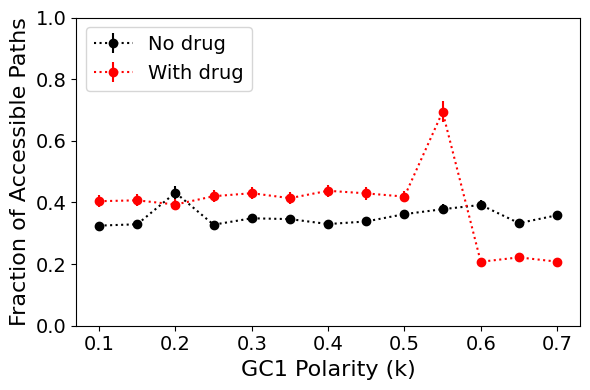

In [38]:

#Plot simulations
plt.figure(figsize=(6, 4))
plt.errorbar(ks, 100 * np.array(mean_paths_ks_nodrug), 100 * np.array(ste_paths_ks_nodrug), marker='o', linestyle=':', color='black', label='No drug')
plt.xlabel('GC1 Polarity (k)', fontsize=16)
plt.ylabel('Fraction of Accessible Paths', fontsize=16)
plt.errorbar(ks, 100 * np.array(mean_paths_ks_drug), 100 * np.array(ste_paths_ks_drug), marker='o', linestyle=':', color='red', label='With drug')
plt.legend(fontsize=14, loc='upper left')
plt.grid(False)
plt.ylim([0, 1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

outPath=f"{dirNameFigures}/X_GC1_GC2_PathsPolarity.pdf"
plt.savefig(outPath, format='pdf', bbox_inches='tight', pad_inches=0.2)
print(f"Exporting {outPath}")
plt.show()


In [ ]:
def compute_mean_path_distance(dirNameData, nreps, this_drug, k):
    """
    Computes the mean distance of paths between random genotypes and the highest fitness peak.

    Parameters:
        dirNameData (str): Directory path containing the data files.
        nreps (int): Number of repetitions for random genotype sampling.
        this_drug (float): Drug concentration for the simulation.
        k (float): Shuffling rate parameter.

    Returns:
        float: Mean distance of accessible paths.
        float: Standard error of the mean distance.
    """

    # Load strain parameters
    file_name_strains = f"{dirNameData}/X_GC1_GC2_k{int(k*100)}e-2_strains.pkl"
    strains = load_strains_parameters(file_name_strains)

    # Construct the tree
    M_exc, M_int, M_dup, list_genotypes = construct_transition_matrices(num_cassettes)
    labels_genotypes = [format_genotype_label(g, num_cassettes) for g in list_genotypes]

    weights = [0.4, 0.4, 0.2]  # 40% weight to M_exc, 40% to M_int, and 20% to M_dup
    M = merge_matrices_with_diagonal_weighted(M_exc, M_int, M_dup, weights=[0.4, 0.4, 0.2])


    accessibility_tree_labels = construct_accessibility_tree_by_label(
        initial_genotype_label,
        labels_genotypes,
        M
    )
    keys_list = list(accessibility_tree_labels.keys())  # Get the list of keys from the dictionary
    strains_accessible = [strain for strain in strains if strain['strainID'] in keys_list]
    labels_genotypes_accessible = [label for label in labels_genotypes if label in keys_list]

    # Find highest fitness peak
    antibiotic_concentrations = [0.0, 0.05, 0.1, 0.25, 0.5, 1.0, 2.0]
    dose_response_accessible_df = run_doseresponse(
        M,
        strains=strains_accessible,
        B0=B0,
        labels_genotypes=labels_genotypes_accessible,
        initial_genotype_label=None,  # All accessible genotypes
        num_days=1,  # Single day
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        dilution_factor=dilution_factor,
        transition_rate=0,  # No transitions during dose-response
        p_sos_min=p_sos_min,
        c_sos=c_sos,
        k_sos=k_sos,
        antibiotic_concentrations=antibiotic_concentrations
    )
    highest_density_label = get_strain_with_highest_density(dose_response_accessible_df, this_drug)

    # Compute relative fitness matrix
    relative_fitness_matrix, accessible_genotypes = compute_relative_fitness_matrix_for_accessible_parallel(
        M,
        strains=strains,
        labels_genotypes=labels_genotypes,
        num_days=1,  # Single day
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        dilution_factor=dilution_factor,
        transition_rate=0.0,  # No transition for competition experiments
        antibiotic_concentration=this_drug,  # Drug concentration
        accessibility_tree=accessibility_tree_labels,
        p_sos_min=p_sos_min, c_sos=c_sos, k_sos=k_sos, max_antibiotic_concentration=1.0
    )

    # Calculate mean distance
    path_distances = []
    for rep in range(nreps):
        filtered_keys = [key for key in accessibility_tree_labels.keys() if key != highest_density_label]
        random_genotype_label = random.choice(filtered_keys)

        # Find accessible paths
        accessible_paths = find_accessible_paths(
            initial_genotype_label=random_genotype_label,
            destination_label=highest_density_label,
            accessibility_tree=accessibility_tree_labels,
            labels_genotypes=labels_genotypes,
            accessible_genotypes=accessible_genotypes,
            relative_fitness_matrix=relative_fitness_matrix
        )

        # Calculate distances for all paths
        distances = [len(path) - 1 for path in accessible_paths]  # Subtract 1 to count edges
        if distances:
            path_distances.append(np.mean(distances))
        else:
            path_distances.append(0)  # No accessible path

        #print(f"{(rep+1)}\t{random_genotype_label} -> {highest_density_label}: Distance = {np.mean(distances) if distances else 0:.2f}")

    # Compute and return the mean and standard error
    mean_distance = np.mean(path_distances)
    ste_distance = np.std(path_distances) / np.sqrt(len(path_distances))
    return mean_distance, ste_distance



In [ ]:
# Run simulations (no drug)
mean_distances_ks_nodrug = []
ste_distances_ks_nodrug = []
for k in ks:
    mean_distance, ste_distance = compute_mean_path_distance(dirNameData, nreps, 0.0, k)
    mean_distances_ks_nodrug.append(mean_distance)
    ste_distances_ks_nodrug.append(ste_distance)
    print(f"Mean path distance (no drug, k={k}): {mean_distance:.2f} ± {ste_distance:.2f}")

# Run simulations (drug)
mean_distances_ks_drug = []
ste_distances_ks_drug = []
for k in ks:
    mean_distance, ste_distance = compute_mean_path_distance(dirNameData, nreps, 1.0, k)
    mean_distances_ks_drug.append(mean_distance)
    ste_distances_ks_drug.append(ste_distance)
    print(f"Mean path distance (drug, k={k}): {mean_distance:.2f} ± {ste_distance:.2f}")


Strain parameters successfully loaded from: /content/drive/MyDrive/SYNC_Projects/MI/data/X_GC1_GC2/X_GC1_GC2_k10e-2_strains.pkl
Mean path distance (no drug, k=0.1): 3.40 ± 0.03
Strain parameters successfully loaded from: /content/drive/MyDrive/SYNC_Projects/MI/data/X_GC1_GC2/X_GC1_GC2_k15e-2_strains.pkl
Mean path distance (no drug, k=0.15): 3.37 ± 0.03
Strain parameters successfully loaded from: /content/drive/MyDrive/SYNC_Projects/MI/data/X_GC1_GC2/X_GC1_GC2_k20e-2_strains.pkl
Mean path distance (no drug, k=0.2): 1.62 ± 0.05
Strain parameters successfully loaded from: /content/drive/MyDrive/SYNC_Projects/MI/data/X_GC1_GC2/X_GC1_GC2_k25e-2_strains.pkl
Mean path distance (no drug, k=0.25): 3.40 ± 0.03
Strain parameters successfully loaded from: /content/drive/MyDrive/SYNC_Projects/MI/data/X_GC1_GC2/X_GC1_GC2_k30e-2_strains.pkl
Mean path distance (no drug, k=0.3): 3.35 ± 0.03
Strain parameters successfully loaded from: /content/drive/MyDrive/SYNC_Projects/MI/data/X_GC1_GC2/X_GC1_GC2_k35e

Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_GC1_GC2/X_GC1_GC2_MeanPathDistance.pdf


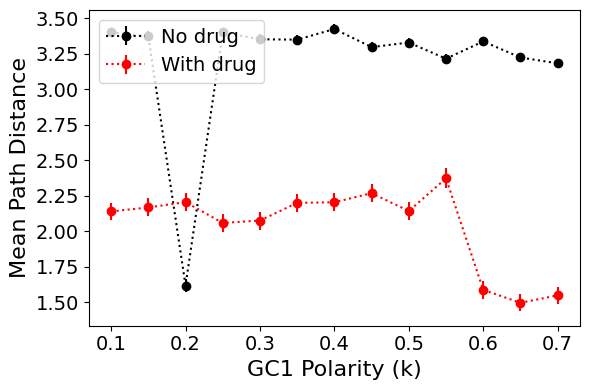

In [37]:

# Plot simulations
plt.figure(figsize=(6, 4))
plt.errorbar(ks, mean_distances_ks_nodrug, ste_distances_ks_nodrug, marker='o', linestyle=':', color='black', label='No drug')
plt.xlabel('GC1 Polarity (k)', fontsize=16)
plt.ylabel('Mean Path Distance', fontsize=16)
plt.errorbar(ks, mean_distances_ks_drug, ste_distances_ks_drug, marker='o', linestyle=':', color='red', label='With drug')
plt.legend(fontsize=14, loc='upper left')
plt.grid(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# Save and show plot
outPath = f"{dirNameFigures}/X_GC1_GC2_MeanPathDistance.pdf"
plt.savefig(outPath, format='pdf', bbox_inches='tight', pad_inches=0.2)
print(f"Exporting {outPath}")
plt.show()

In [ ]:
def compute_basin_of_attraction(dirNameData, this_drug, k):
    """
    Identifies the basin of attraction of the highest fitness genotype by finding all genotypes
    that have accessible paths leading to the highest fitness genotype.

    Parameters:
        dirNameData (str): Directory path containing the data files.
        this_drug (float): Drug concentration for the simulation.
        k (float): Shuffling rate parameter.

    Returns:
        dict: Dictionary containing all required inputs for visualization:
            - basin_of_attraction (list): Genotypes in the basin of attraction.
            - highest_density_label (str): The highest fitness genotype label.
            - accessibility_tree_labels (dict): Accessibility tree.
            - labels_genotypes (list): All genotype labels.
            - relative_fitness_matrix (ndarray): Relative fitness matrix.
            - accessible_genotypes (list): Accessible genotype labels.
            - M_exc (ndarray): Excitation matrix.
            - M_int (ndarray): Interaction matrix.
    """
    # Load strain parameters
    file_name_strains = f"{dirNameData}/X_GC1_GC2_k{int(k*100)}e-2_strains.pkl"
    strains = load_strains_parameters(file_name_strains)

    # Construct the tree
    M_exc, M_int, M_dup, list_genotypes = construct_transition_matrices(num_cassettes)
    labels_genotypes = [format_genotype_label(g, num_cassettes) for g in list_genotypes]

    weights = [0.4, 0.4, 0.2]  # 40% weight to M_exc, 40% to M_int, and 20% to M_dup
    M = merge_matrices_with_diagonal_weighted(M_exc, M_int, M_dup, weights=[0.4, 0.4, 0.2])

    accessibility_tree_labels = construct_accessibility_tree_by_label(
        initial_genotype_label,
        labels_genotypes,
        M
    )
    keys_list = list(accessibility_tree_labels.keys())  # Get the list of keys from the dictionary
    strains_accessible = [strain for strain in strains if strain['strainID'] in keys_list]
    labels_genotypes_accessible = [label for label in labels_genotypes if label in keys_list]

    # Find highest fitness peak
    antibiotic_concentrations = [0.0, 0.05, 0.1, 0.25, 0.5, 1.0, 2.0]
    dose_response_accessible_df = run_doseresponse(
        M,
        strains=strains_accessible,
        B0=B0,
        labels_genotypes=labels_genotypes_accessible,
        initial_genotype_label=None,  # All accessible genotypes
        num_days=1,  # Single day
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        dilution_factor=dilution_factor,
        transition_rate=0,  # No transitions during dose-response
        p_sos_min=p_sos_min,
        c_sos=c_sos,
        k_sos=k_sos,
        antibiotic_concentrations=antibiotic_concentrations
    )
    highest_density_label = get_strain_with_highest_density(dose_response_accessible_df, this_drug)

    # Compute relative fitness matrix
    relative_fitness_matrix, accessible_genotypes = compute_relative_fitness_matrix_for_accessible_parallel(
        M,
        strains=strains,
        labels_genotypes=labels_genotypes,
        num_days=1,  # Single day
        initial_resource=initial_resource,
        simulation_time=simulation_time,
        dilution_factor=dilution_factor,
        transition_rate=0.0,  # No transition for competition experiments
        antibiotic_concentration=this_drug,  # Drug concentration
        accessibility_tree=accessibility_tree_labels,
        p_sos_min=p_sos_min, c_sos=c_sos, k_sos=k_sos, max_antibiotic_concentration=1.0
    )

    # Identify the basin of attraction
    basin_of_attraction = []

    for genotype_label in accessibility_tree_labels.keys():
        # Skip the highest density label itself
        if genotype_label == highest_density_label:
            continue

        # Check if there are accessible paths
        accessible_paths = find_accessible_paths(
            initial_genotype_label=genotype_label,
            destination_label=highest_density_label,
            accessibility_tree=accessibility_tree_labels,
            labels_genotypes=labels_genotypes,
            accessible_genotypes=accessible_genotypes,
            relative_fitness_matrix=relative_fitness_matrix
        )

        if accessible_paths:
            basin_of_attraction.append(genotype_label)

    print(f"Basin of attraction size: {len(basin_of_attraction)}")

    # Return all required inputs for visualization
    return {
        "basin_of_attraction": basin_of_attraction,
        "highest_density_label": highest_density_label,
        "accessibility_tree_labels": accessibility_tree_labels,
        "labels_genotypes": labels_genotypes,
        "relative_fitness_matrix": relative_fitness_matrix,
        "accessible_genotypes": accessible_genotypes,
        "M_exc": M_exc,
        "M_int": M_int,
        "M": M,
    }



In [ ]:
def visualize_basin_of_attraction(
    initial_genotype_label, destination_genotype_label, labels_genotypes, M,
    relative_fitness_matrix, accessible_genotypes, basin_of_attraction, title='', outPath=''
):
    """
    Visualizes the accessibility tree using NetworkX and Matplotlib with nodes organized in layers.
    Basin of attraction nodes are colored orange, and paths within the basin are orange.
    Only edges with relative fitness >1 are orange. All other nodes are gray,
    except for the destination genotype, which is red.

    Parameters:
        initial_genotype_label (str): The initial genotype label.
        destination_genotype_label (str): The destination genotype label.
        labels_genotypes (list): List of genotype labels corresponding to the indices.
        M_exc (ndarray): Excitation matrix.
        M_int (ndarray): Interaction matrix.
        relative_fitness_matrix (ndarray): Matrix of relative fitness values between accessible genotypes.
        accessible_genotypes (list): List of accessible genotype labels corresponding to the reduced matrix.
        basin_of_attraction (list): List of genotypes in the basin of attraction.
        title (str): Title for the plot.
        outPath (str): Output path to save the plot.

    Returns:
        None: Displays or saves the graph.
    """
    # Find the index corresponding to the initial_genotype_label
    if initial_genotype_label not in labels_genotypes:
        raise ValueError(f"Initial genotype label '{initial_genotype_label}' not found in labels_genotypes.")
    initial_genotype_index = labels_genotypes.index(initial_genotype_label)

    # Construct the accessibility tree from the initial genotype
    tree = construct_accessibility_tree(initial_genotype_index, M)

    # Create a directed graph
    G = nx.DiGraph()
    edge_colors = []  # To store edge colors
    edge_weights = []  # To store edge widths

    # Map original genotype indices to accessible genotype indices
    accessible_indices_map = {label: idx for idx, label in enumerate(accessible_genotypes)}

    # Add nodes and edges to the graph
    for parent, children in tree.items():
        parent_label = labels_genotypes[parent]  # Convert index to label
        if parent_label not in accessible_indices_map:
            continue  # Skip nodes not in the accessible genotypes

        for child in children:
            if parent != child:  # Skip self-loops
                child_label = labels_genotypes[child]  # Convert index to label
                if child_label not in accessible_indices_map:
                    continue  # Skip nodes not in the accessible genotypes

                G.add_edge(parent_label, child_label)

                # Determine the edge color based on relative fitness
                parent_idx = accessible_indices_map[parent_label]
                child_idx = accessible_indices_map[child_label]
                relative_fitness = relative_fitness_matrix[parent_idx, child_idx]
                relative_fitness = relative_fitness if np.isfinite(relative_fitness) else 1.0

                # Color edges orange if fitness >1 and:
                # - Both nodes are in the basin of attraction OR
                # - The edge leads to the destination genotype
                if relative_fitness > 1 and (
                    (parent_label in basin_of_attraction and child_label in basin_of_attraction) or
                    (parent_label in basin_of_attraction and child_label == destination_genotype_label)
                ):
                    edge_colors.append('orange')
                else:
                    edge_colors.append('lightgray')  # Non-basin edges
                edge_weights.append(2)


    # Compute distances from the initial genotype
    distances = {initial_genotype_label: 0}
    queue = [(initial_genotype_label, 0)]
    while queue:
        current, dist = queue.pop(0)
        for neighbor in G.successors(current):
            if neighbor not in distances:
                distances[neighbor] = dist + 1
                queue.append((neighbor, dist + 1))

    # Organize nodes into layers based on their distance
    layers = defaultdict(list)
    for node, distance in distances.items():
        layers[distance].append(node)

    # Sort nodes within each layer alphabetically
    for layer in layers.values():
        layer.sort()

    # Create a layered layout
    pos = {}
    y_spacing = 3  # Vertical space between layers
    x_spacing = 2  # Horizontal space between nodes
    for y, (distance, nodes) in enumerate(sorted(layers.items())):
        for x, node in enumerate(nodes):
            pos[node] = (x * x_spacing, -y * y_spacing)

    # Draw the graph
    plt.figure(figsize=(12, 8))
    node_colors = [
        'red' if node == destination_genotype_label else
        'orange' if node in basin_of_attraction else
        'lightgray'
        for node in G.nodes()
    ]
    nx.draw(
        G, pos, with_labels=True, node_size=3000, node_color=node_colors,
        font_size=10, font_weight="bold", arrowsize=20, edge_color=edge_colors, width=edge_weights
    )

    # Add a legend for edge and node colors
    legend_elements = [
        plt.Line2D([0], [0], color='orange', lw=2, label='Edge with Fitness > 1 (Basin of Attraction)'),
        plt.Line2D([0], [0], color='lightgray', lw=2, label='Non-Basin Path'),
        plt.Line2D([0], [0], color='red', marker='o', markersize=10, label='Highest Fitness Genotype', lw=0),
        plt.Line2D([0], [0], color='orange', marker='o', markersize=10, label='Basin of Attraction Genotype', lw=0)
    ]
    plt.legend(handles=legend_elements, loc='best', fontsize=12)
    plt.title(title, fontsize=16)

    # Save or show plot
    if outPath:
        filename = f"{outPath}_basinOfAttraction.pdf"
        plt.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0.2)
        print(f"Exporting {filename}")
        plt.show()
        plt.close()
    else:
        plt.show()


In [ ]:
results_A0_k10e = compute_basin_of_attraction(dirNameData, this_drug=0.0, k=0.1)
visualize_basin_of_attraction(
    initial_genotype_label='12X',
    destination_genotype_label=results_A0_k10e["highest_density_label"],
    labels_genotypes=results_A0_k10e["labels_genotypes"],
    M=results_A0_k10e["M"],
    relative_fitness_matrix=results_A0_k10e["relative_fitness_matrix"],
    accessible_genotypes=results_A0_k10e["accessible_genotypes"],
    basin_of_attraction=results_A0_k10e["basin_of_attraction"],
    title="No drug (k=%s)"%(0.1),
    outPath=''
)

results_A0_k40e = compute_basin_of_attraction(dirNameData, this_drug=0.0, k=0.4)
visualize_basin_of_attraction(
    initial_genotype_label='12X',
    destination_genotype_label=results_A0_k40e["highest_density_label"],
    labels_genotypes=results_A0_k40e["labels_genotypes"],
    M=results_A0_k40e["M"],
    relative_fitness_matrix=results_A0_k40e["relative_fitness_matrix"],
    accessible_genotypes=results_A0_k40e["accessible_genotypes"],
    basin_of_attraction=results_A0_k40e["basin_of_attraction"],
    title="No drug (k=%s)"%(0.4),
    outPath=''
)


results_A0_k70e = compute_basin_of_attraction(dirNameData, this_drug=0.0, k=0.7)
visualize_basin_of_attraction(
    initial_genotype_label='12X',
    destination_genotype_label=results_A0_k70e["highest_density_label"],
    labels_genotypes=results_A0_k70e["labels_genotypes"],
    M=results_A0_k70e["M"],
    relative_fitness_matrix=results_A0_k70e["relative_fitness_matrix"],
    accessible_genotypes=results_A0_k70e["accessible_genotypes"],
    basin_of_attraction=results_A0_k70e["basin_of_attraction"],
    title="No drug (k=%s)"%(0.7),
    outPath=''
)


In [ ]:




results_A1_k10e = compute_basin_of_attraction(dirNameData, this_drug=1.0, k=0.10)
visualize_basin_of_attraction(
    initial_genotype_label='12X',
    destination_genotype_label=results_A1_k10e["highest_density_label"],
    labels_genotypes=results_A1_k10e["labels_genotypes"],
    M=results_A1_k10e["M"],
    relative_fitness_matrix=results_A1_k10e["relative_fitness_matrix"],
    accessible_genotypes=results_A1_k10e["accessible_genotypes"],
    basin_of_attraction=results_A1_k10e["basin_of_attraction"],
    title="With drug (k=%s)"%(0.10),
    outPath=''
)


results_A1_k40e = compute_basin_of_attraction(dirNameData, this_drug=1.0, k=0.4)
visualize_basin_of_attraction(
    initial_genotype_label='12X',
    destination_genotype_label=results_A1_k40e["highest_density_label"],
    labels_genotypes=results_A1_k40e["labels_genotypes"],
    M=results_A1_k40e["M"],
    relative_fitness_matrix=results_A1_k40e["relative_fitness_matrix"],
    accessible_genotypes=results_A1_k40e["accessible_genotypes"],
    basin_of_attraction=results_A1_k40e["basin_of_attraction"],
    title="With drug (k=%s)"%(0.4),
    outPath=''
)


results_A1_k70e = compute_basin_of_attraction(dirNameData, this_drug=1.0, k=0.7)
visualize_basin_of_attraction(
    initial_genotype_label='12X',
    destination_genotype_label=results_A1_k70e["highest_density_label"],
    labels_genotypes=results_A1_k70e["labels_genotypes"],
    M=results_A1_k70e["M"],
    relative_fitness_matrix=results_A1_k70e["relative_fitness_matrix"],
    accessible_genotypes=results_A1_k70e["accessible_genotypes"],
    basin_of_attraction=results_A1_k70e["basin_of_attraction"],
    title="With drug (k=%s)"%(0.7),
    outPath=''
)




Strain parameters successfully loaded from: /content/drive/MyDrive/SYNC_Projects/MI/data/X_GC1_GC2/X_GC1_GC2_k10e-2_strains.pkl
Basin of attraction size: 39
Drug: 0.0, k: 0.1, Basin size: 9
Strain parameters successfully loaded from: /content/drive/MyDrive/SYNC_Projects/MI/data/X_GC1_GC2/X_GC1_GC2_k15e-2_strains.pkl
Basin of attraction size: 39
Drug: 0.0, k: 0.15, Basin size: 9
Strain parameters successfully loaded from: /content/drive/MyDrive/SYNC_Projects/MI/data/X_GC1_GC2/X_GC1_GC2_k20e-2_strains.pkl
Basin of attraction size: 39
Drug: 0.0, k: 0.2, Basin size: 9
Strain parameters successfully loaded from: /content/drive/MyDrive/SYNC_Projects/MI/data/X_GC1_GC2/X_GC1_GC2_k25e-2_strains.pkl
Basin of attraction size: 39
Drug: 0.0, k: 0.25, Basin size: 9
Strain parameters successfully loaded from: /content/drive/MyDrive/SYNC_Projects/MI/data/X_GC1_GC2/X_GC1_GC2_k30e-2_strains.pkl
Basin of attraction size: 39
Drug: 0.0, k: 0.3, Basin size: 9
Strain parameters successfully loaded from: /con

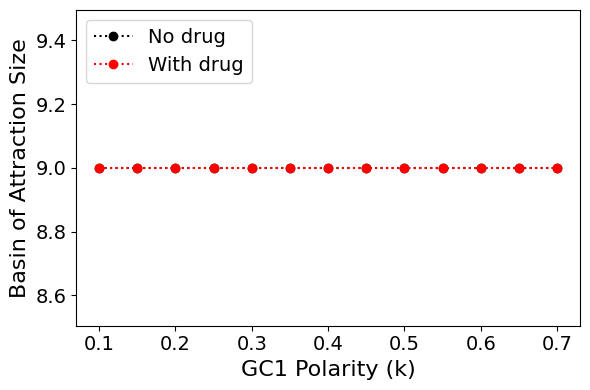

In [35]:
this_drug_values = [0.0, 1.0]  # No drug and with drug
ks=[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
basin_sizes_nodrug = []
basin_sizes_drug = []

# Run simulations for each drug condition
for this_drug in this_drug_values:
    basin_sizes = []  # Temporary list for storing basin sizes for this drug condition
    for k in ks:
        # Compute the basin of attraction
        basin_of_attraction = compute_basin_of_attraction(dirNameData, this_drug, k)
        basin_size = len(basin_of_attraction)  # Size of the basin of attraction
        basin_sizes.append(basin_size)
        print(f"Drug: {this_drug}, k: {k}, Basin size: {basin_size}")

    if this_drug == 0.0:
        basin_sizes_nodrug = basin_sizes
    else:
        basin_sizes_drug = basin_sizes




Exporting /content/drive/MyDrive/SYNC_Projects/MI/figures/X_GC1_GC2/X_GC1_GC2_BasinAttractionSizes.pdf


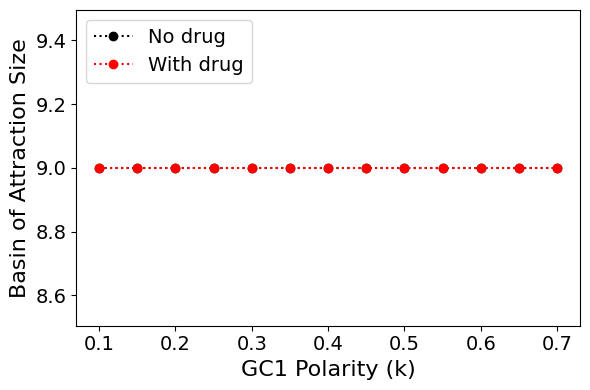

In [36]:
# Plot results
plt.figure(figsize=(6, 4))
plt.plot(ks, basin_sizes_nodrug, marker='o', linestyle=':', color='black', label='No drug')
plt.plot(ks, basin_sizes_drug, marker='o', linestyle=':', color='red', label='With drug')
plt.xlabel('GC1 Polarity (k)', fontsize=16)
plt.ylabel('Basin of Attraction Size', fontsize=16)
plt.legend(fontsize=14, loc='upper left')
plt.grid(False)
#plt.ylim([0, max(max(basin_sizes_nodrug), max(basin_sizes_drug)) * 1.1])  # Adjust y-axis limit
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# Save or show the plot
outPath = f"{dirNameFigures}/X_GC1_GC2_BasinAttractionSizes.pdf"
plt.savefig(outPath, format='pdf', bbox_inches='tight', pad_inches=0.2)
print(f"Exporting {outPath}")
plt.show()